In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from donut import Donut
from tensorflow import keras as K
from tfsnippet.modules import Sequential
from donut import complete_timestamp, standardize_kpi

/Users/anaisdotis-georgiou/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/anaisdotis-georgiou/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/anaisdotis-georgiou/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/anaisdotis-georgiou/anaconda3/lib

/Users/anaisdotis-georgiou/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/anaisdotis-georgiou/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/anaisdotis-georgiou/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/anaisdotis-g

In [3]:
cpu = pd.read_csv("donut/sample_data/cpu4.csv")
cpu.head()
cpu.size

52704

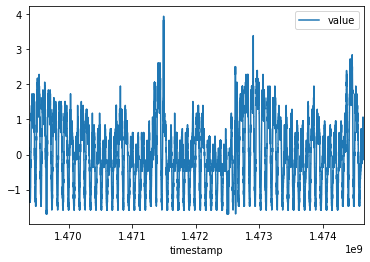

In [4]:
cpu.plot(x='timestamp', y='value')

In [5]:
timestamp, values, labels = cpu.timestamp, cpu.value, cpu.label 

In [6]:
# Complete the timestamp, and obtain the missing point indicators.
timestamp, missing, (values, labels) = complete_timestamp(timestamp, (values, labels))

In [7]:
# Split the training and testing data.
test_portion = 0.3
test_n = int(len(values) * test_portion)
train_values, test_values = values[:-test_n], values[-test_n:]
train_labels, test_labels = labels[:-test_n], labels[-test_n:]
train_missing, test_missing = missing[:-test_n], missing[-test_n:]

# Standardize the training and testing data.
train_values, mean, std = standardize_kpi(
    train_values, excludes=np.logical_or(train_labels, train_missing))
test_values, _, _ = standardize_kpi(test_values, mean=mean, std=std)

In [8]:
import tensorflow as tf
from donut import Donut
from tensorflow import keras as K
from tfsnippet.modules import Sequential

# We build the entire model within the scope of `model_vs`,
# it should hold exactly all the variables of `model`, including
# the variables created by Keras layers.
with tf.variable_scope('model') as model_vs:
    model = Donut(
        h_for_p_x=Sequential([
            K.layers.Dense(100, kernel_regularizer=K.regularizers.l2(0.001),
                           activation=tf.nn.relu),
            K.layers.Dense(100, kernel_regularizer=K.regularizers.l2(0.001),
                           activation=tf.nn.relu),
        ]),
        h_for_q_z=Sequential([
            K.layers.Dense(100, kernel_regularizer=K.regularizers.l2(0.001),
                           activation=tf.nn.relu),
            K.layers.Dense(100, kernel_regularizer=K.regularizers.l2(0.001),
                           activation=tf.nn.relu),
        ]),
        x_dims=120,
        z_dims=5,
    )

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor




In [9]:
from donut import DonutTrainer, DonutPredictor

trainer = DonutTrainer(model=model, model_vs=model_vs)
predictor = DonutPredictor(model)

with tf.Session().as_default():
    trainer.fit(train_values, train_labels, train_missing, mean, std)
    test_score = predictor.get_score(test_values, test_missing)

Instructions for updating:
Use keras.layers.dense instead.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Trainable Parameters                     (58,150 in total)
----------------------------------------------------------
donut/p_x_given_z/x_mean/bias           (120,)         120
donut/p_x_given_z/x_mean/kernel         (100, 120)  12,000
donut/p_x_given_z/x_std/bias            (120,)         120
donut/p_x_given_z/x_std/kernel          (100, 120)  12,000
donut/q_z_given_x/z_mean/bias           (5,)             5
donut/q_z_given_x/z_mean/kernel         (100, 5)       500
donut/q_z_given_x/z_std/bias            (5,)             5
donut/q_z_given_x/z_std/kernel          (100, 5)       500
sequential/forward/_0/dense/bias        (100,)         100
sequential/forward/_0/dense/kernel      (5, 100)       500
sequential/forward/_1/dense_1/bias      (100,)         100
sequential/forward/_1/dense_1/kernel    (100, 100)  10,000
sequential_1/forw

[Epoch 30/256, Step 990, ETA 39.38s] Learning rate decreased to 0.00042187500000000005
[Epoch 31/256, Step 1000, ETA 39.97s] step time: 0.004783s (±0.009262s); valid time: 0.09318s; loss: -61.9666 (±1.78597); valid loss: -57.662 (*)
[Epoch 34/256, Step 1100, ETA 39.41s] step time: 0.004689s (±0.009266s); valid time: 0.09079s; loss: -62.8265 (±1.98965); valid loss: -58.3207 (*)
[Epoch 37/256, Step 1200, ETA 38.12s] step time: 0.003487s (±0.001305s); valid time: 0.01222s; loss: -63.8401 (±2.1452); valid loss: -58.1298
[Epoch 40/256, Step 1300, ETA 37.93s] step time: 0.005049s (±0.01004s); valid time: 0.101s; loss: -64.5099 (±2.10708); valid loss: -58.7416 (*)
[Epoch 40/256, Step 1320, ETA 37.78s] Learning rate decreased to 0.00031640625000000006
[Epoch 43/256, Step 1400, ETA 37.61s] step time: 0.005012s (±0.01043s); valid time: 0.1028s; loss: -65.0963 (±2.1055); valid loss: -60.0558 (*)
[Epoch 46/256, Step 1500, ETA 36.62s] step time: 0.003689s (±0.001984s); valid time: 0.01731s; loss: -

[Epoch 176/256, Step 5800, ETA 13.43s] step time: 0.004048s (±0.001509s); valid time: 0.01455s; loss: -72.4233 (±1.80289); valid loss: -64.3319
[Epoch 179/256, Step 5900, ETA 12.91s] step time: 0.004146s (±0.001465s); valid time: 0.01462s; loss: -72.9455 (±1.59057); valid loss: -64.487
[Epoch 180/256, Step 5940, ETA 12.69s] Learning rate decreased to 5.637710113660432e-06
[Epoch 182/256, Step 6000, ETA 12.41s] step time: 0.004608s (±0.009206s); valid time: 0.09254s; loss: -72.8432 (±1.95934); valid loss: -64.6638 (*)
[Epoch 185/256, Step 6100, ETA 11.9s] step time: 0.004492s (±0.008907s); valid time: 0.08948s; loss: -72.4855 (±1.9102); valid loss: -64.7073 (*)
[Epoch 188/256, Step 6200, ETA 11.37s] step time: 0.003623s (±0.001158s); valid time: 0.0114s; loss: -72.5802 (±1.89457); valid loss: -64.4639
[Epoch 190/256, Step 6270, ETA 10.99s] Learning rate decreased to 4.228282585245324e-06
[Epoch 191/256, Step 6300, ETA 10.83s] step time: 0.003697s (±0.001527s); valid time: 0.01485s; loss

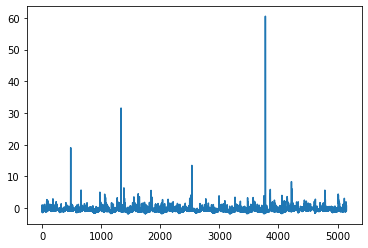

In [10]:
#  Get the `reconstruction probability` of specified KPI observations.
#         The larger `reconstruction probability`, the less likely a point
#         is anomaly.  You may take the negative of the score, if you want
#         something to directly indicate the severity of anomaly.
#         Args:
#             values (np.ndarray): 1-D float32 array, the KPI observations.
#             missing (np.ndarray): 1-D int32 array, the indicator of missing
#                 points.  If :obj:`None`, the MCMC missing data imputation
#                 will be disabled. (default :obj:`None`)
#         Returns:
#             np.ndarray: The `reconstruction probability`,
#                 1-D array if `last_point_only` is :obj:`True`,
#                 or 2-D array if `last_point_only` is :obj:`False`.

# test_score multiplied by -1 as directed by code comments 
plt.plot(test_score*-1)

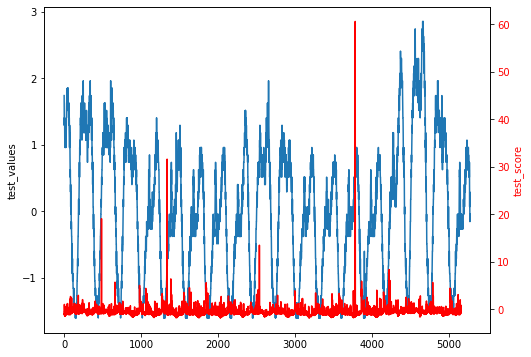

In [11]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.plot(test_values)
ax1.set_ylabel('test_values')

ax2 = ax1.twinx()
ax2.plot(test_score*-1, 'r-')
ax2.set_ylabel('test_score', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')

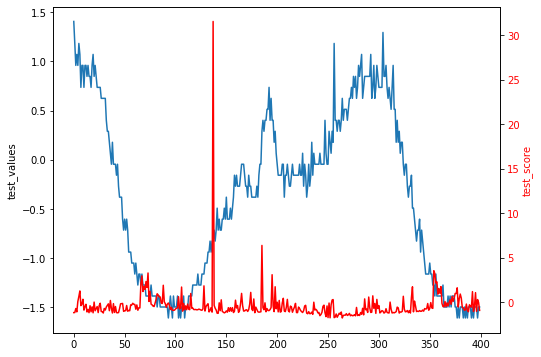

In [14]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.plot(test_values[1200:1600])
ax1.set_ylabel('test_values')

ax2 = ax1.twinx()
ax2.plot(test_score[1200:1600]*-1, 'r-')
ax2.set_ylabel('test_score', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')

In [63]:
test_score.size

5151

In [21]:
zeros = [0] * 119
ts =  np.concatenate((zeros, test_score), axis=None)
ts

array([ 0.        ,  0.        ,  0.        , ...,  0.61521691,
       -0.90537238,  0.70290565])

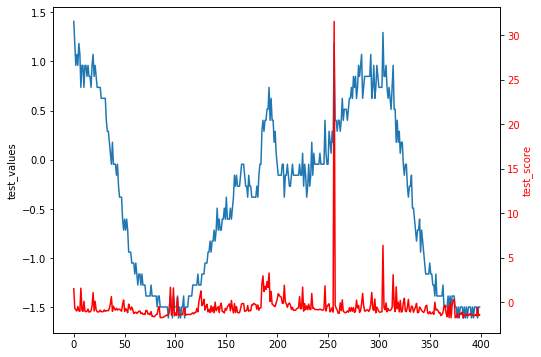

In [23]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.plot(test_values[1200:1600])
ax1.set_ylabel('test_values')

ax2 = ax1.twinx()
ax2.plot(ts[1200:1600]*-1, 'r-')
ax2.set_ylabel('test_score', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')

In [57]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.plot(test_values)
ax1.set_ylabel('test_values')

ax2 = ax1.twinx()
ax2.plot(ts*-1, 'r-')
ax2.set_ylabel('test_score', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')

5270

In [13]:
n = 5270 - 5151
n

119